Mając już dane zabieram się za implementacji vq-vae dla naszego zbioru

In [33]:
import torch.optim as optim
import numpy as np
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from PIL import Image
import io
from datasets import load_from_disk
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
import torch
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Wczytanie i przetworzenie

## wczytanie

In [34]:
from datasets import load_from_disk

dataset = load_from_disk('/content/drive/MyDrive/datasets/minecraft_dataset_vectors')
ds = dataset.to_pandas()
ds

image  is_block  \
0     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
1     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
2     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
3     {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
4     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
...                                                 ...       ...   
1513  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
1514  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1515  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1516  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1517  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   

                                                   type  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
1513  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1514  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
1515  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1516  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1517  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   

                                                 colors  
0     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
3     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
...                                                 ...  
1513  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1514  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1515  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1516  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
1517  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  

[1518 rows x 4 columns]

In [35]:
ds.shape

(1518, 4)

## przetworzenie zbioru

In [36]:
mask = []
for index, row in ds.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    mask.append((img.width == 16) & (img.height == 16))

ds = ds[mask]
ds

image  is_block  \
0     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
1     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
2     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
3     {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
4     {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
...                                                 ...       ...   
1513  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         1   
1514  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1515  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1516  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   
1517  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...         0   

                                                   type  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
1513  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1514  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
1515  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1516  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1517  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   

                                                 colors  
0     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
3     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
...                                                 ...  
1513  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1514  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1515  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1516  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
1517  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  

[1499 rows x 4 columns]

In [37]:
ds.shape

(1499, 4)

## Stworzenie dataloader

In [38]:
class MinecraftDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = Compose([
            ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # get image
        img_bytes = self.dataframe.iloc[idx]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert("RGBA")
        img_tensor = self.transform(img)
        img_tensor = (img_tensor - 0.5) / 0.5  # normalization

        is_block = float(self.dataframe.iloc[idx]['is_block'])
        is_block = torch.tensor(is_block, dtype=torch.float32)

        type_ = self.dataframe.iloc[idx]['type']
        type_tensor = torch.tensor(type_, dtype=torch.float32).flatten()

        colors = self.dataframe.iloc[idx]['colors']
        colors_tensor = torch.tensor(colors, dtype=torch.float32).flatten()

        return img_tensor, is_block, type_tensor, colors_tensor

In [39]:
# parameters
batch_size = 32
lr = 1e-4

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
use_cuda

True

In [40]:
dataset = MinecraftDataset(ds)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Trening

In [41]:
dataiter = iter(train_loader)
test_1 = next(dataiter)[0]
test_2 = next(dataiter)[0]
test_3 = next(dataiter)[0]
test_images = torch.cat((test_1, test_2, test_3), 0)


print(test_images.shape) # batch size, number of columns, img_x, img_y

torch.Size([96, 4, 16, 16])


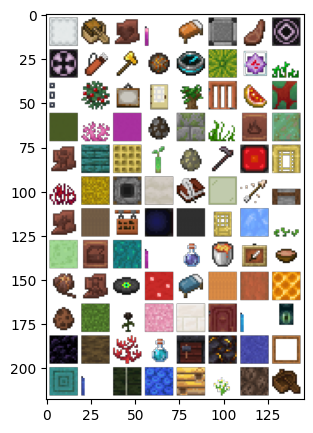

In [42]:
plt.figure(figsize = (5,5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

### nasza sieć

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1/code_book_size, 1/code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # BSxCxHxW --> BSxHxWxC
        input_shape = inputs.shape

        flat_input = inputs.view(-1, 1, self.embedding_dim)  # BSxHxWxC --> BS*H*Wx1xC

        # Calculate the distance between each embedding and each codebook vector
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)  # BS*H*WxN

        # Find the closest codebook vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # BS*H*Wx1

        # Select that codebook vector
        quantized = self.embedding(encoding_indices).view(input_shape)

        # Create loss that pulls encoder embeddings and codebook vector selected
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Reconstruct quantized representation using the encoder embeddings to allow for
        # backpropagation of gradients into encoder
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        skip = x

        x = F.elu(self.norm1(x))
        x = F.elu(self.norm2(self.conv1(x)))
        x = self.conv2(x) + skip
        return x


# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn2 = nn.GroupNorm(8, channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x = F.elu(self.bn1(x))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.GroupNorm(8, channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = self.up_nn(F.elu(self.bn1(x_in)))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip

# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch * 2)
        self.conv_block2 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_out = nn.Conv2d(4 * ch, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv_1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = F.elu(self.res_block_3(x))

        return self.conv_out(x)


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(latent_channels, 4 * ch, 3, 1, 1)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_2(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        return torch.tanh(self.conv_out(x))

class VQVAE(nn.Module):
    def __init__(self,
                 channel_in,
                 ch=16,
                 latent_channels=32,
                 code_book_size=64,
                 commitment_cost=0.25,
                 cond_type_dim=8,     # len(type)
                 cond_colors_dim=8,   # len(colors)
                 cond_hidden=256):    # for condition
        super(VQVAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        self.vq = VectorQuantizer(code_book_size=code_book_size,
                                  embedding_dim=latent_channels,
                                  commitment_cost=commitment_cost)

        self.decoder = Decoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        # conditioning: is_block (1), type (cond_type_dim), colors (cond_colors_dim)
        self.cond_in_dim = 1 + cond_type_dim + cond_colors_dim
        self.cond_hidden = cond_hidden
        self.latent_channels = latent_channels

        # MLP to map condition vector -> latent_channels
        self.cond_fc = nn.Sequential(
            nn.Linear(self.cond_in_dim, self.cond_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.cond_hidden, latent_channels)
        )

    def encode(self, x, is_block=None, type_=None, colors=None):
        encoding = self.encoder(x)

        if is_block is not None and type_ is not None and colors is not None:
            cond_vec = torch.cat([is_block.unsqueeze(1), type_, colors], dim=1)  # (B, cond_dim)
            cond_proj = self.cond_fc(cond_vec)  # (B, latent_channels)

            # reshape to (B, latent_channels, 1, 1) and broadcast add
            cond_proj = cond_proj.unsqueeze(-1).unsqueeze(-1)
            encoding = encoding + cond_proj

        vq_loss, quantized, encoding_indices = self.vq(encoding)
        return vq_loss, quantized, encoding_indices

    def decode(self, x, is_block=None, type_=None, colors=None):
        if is_block is not None and type_ is not None and colors is not None:
            cond_vec = torch.cat([is_block.unsqueeze(1), type_, colors], dim=1)
            cond_proj = self.cond_fc(cond_vec)  # (B, latent_channels)
            cond_proj = cond_proj.unsqueeze(-1).unsqueeze(-1)
            x = x + cond_proj

        return self.decoder(x)

    def forward(self, x, is_block=None, type_=None, colors=None):
        vq_loss, quantized, encoding_indices = self.encode(x, is_block, type_, colors)
        recon = self.decode(quantized, is_block, type_, colors)
        return recon, vq_loss, quantized

### definicja parametrów uczenia

In [44]:
# The number of code book embeddings
code_book_size =  512

# The number of latent embedding channels
latent_channels = 256

# Number of Training epochs
vq_nepoch = 500

type_dim = len(ds.iloc[0]['type'])
colors_dim = len(ds.iloc[0]['colors'])

vae_net = VQVAE(channel_in=4, latent_channels=latent_channels, ch=128,
                code_book_size=code_book_size, commitment_cost=0.50,
                cond_type_dim=type_dim, cond_colors_dim=colors_dim, cond_hidden=256).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, weight_decay=1e-5)
scaler = torch.amp.GradScaler('cuda')

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=vq_nepoch, eta_min=0)

# Create loss logger
recon_loss_log = []
qv_loss_log = []
test_recon_loss_log = []
train_loss = 0

In [45]:
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]

print("-The VQVAE Model Has %d (Approximately %d Million) Parameters!" % (num_model_params,
                                                                          num_model_params//1e6))

-The VQVAE Model Has 38004612 (Approximately 38 Million) Parameters!


In [46]:
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

quantized.shape

torch.Size([96, 256, 4, 4])

In [47]:
recon_loss_log = []
qv_loss_log = []
test_recon_loss_log = []

patience = 50
min_delta = 0.0
best_loss = float("inf")
counter = 0

pbar = trange(0, vq_nepoch, leave=False, desc="Epoch")
for epoch in pbar:
    train_loss = 0
    vae_net.train()
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        image = data[0].to(device)
        is_block = data[1].to(device)
        type_ = data[2].to(device)
        colors = data[3].to(device)

        with torch.amp.autocast('cuda'):
            recon_data, vq_loss, quantized = vae_net(image, is_block=is_block, type_=type_, colors=colors)
            recon_loss = (recon_data - image).pow(2).mean()
            loss = vq_loss + recon_loss

        optimizer.zero_grad()
        if device == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        recon_loss_log.append(recon_loss.item())
        qv_loss_log.append(vq_loss.item())
        train_loss += recon_loss.item()

    lr_scheduler.step()

    vae_net.eval()

    pbar.set_postfix_str(f"Train: {train_loss/len(train_loader):.4f}")

    if recon_loss < best_loss - min_delta:
        best_loss = recon_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

## Sprawdzenie metryk po treningu

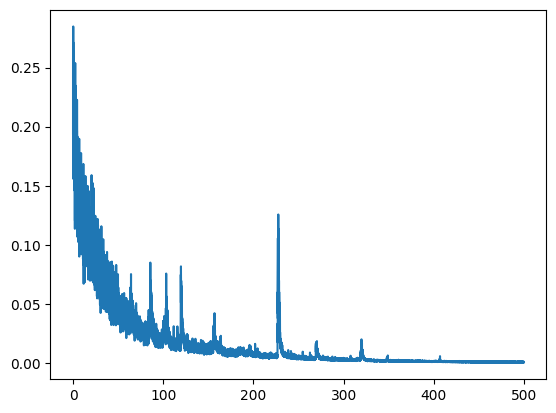

In [48]:
# Results
x_train = np.linspace(0, vq_nepoch, len(recon_loss_log[200:]))
_ = plt.plot(x_train, recon_loss_log[200:])

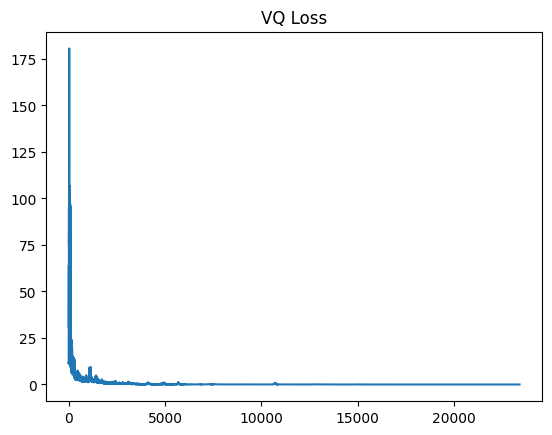

In [49]:
_ = plt.plot(qv_loss_log[100:])
_ = plt.title("VQ Loss")

In [50]:
vae_net.eval()
dataiter = iter(train_loader)
test_batch = next(dataiter)
image = test_batch[0].to(device)
is_block = test_batch[1].to(device)
type_ = test_batch[2].to(device)
colors = test_batch[3].to(device)

with torch.no_grad():
    recon_data, _, _ = vae_net(image, is_block=is_block, type_=type_, colors=colors)

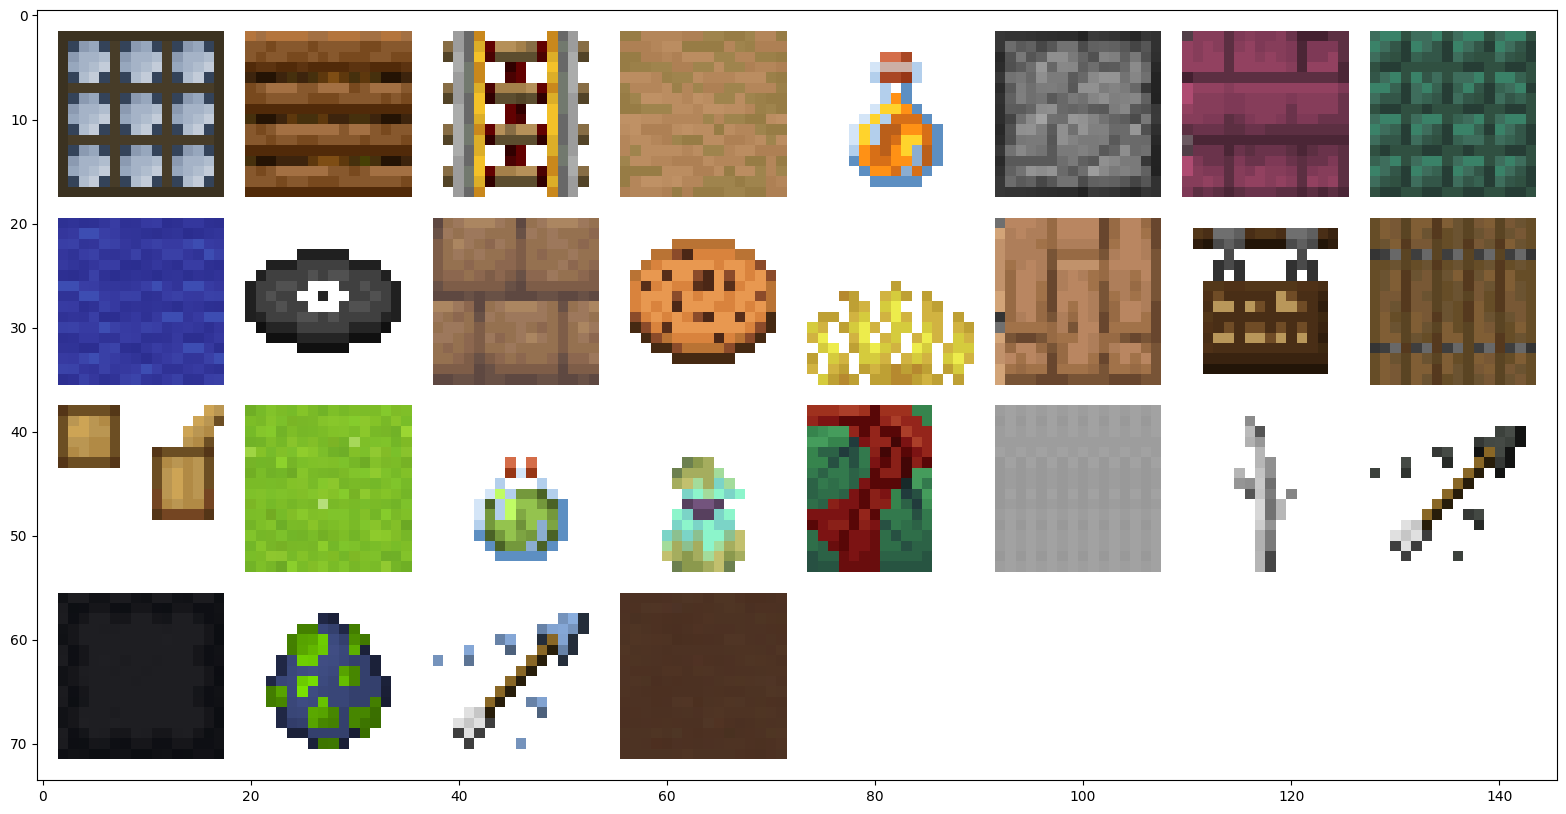

In [51]:
# ground truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_batch[0][0:28], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

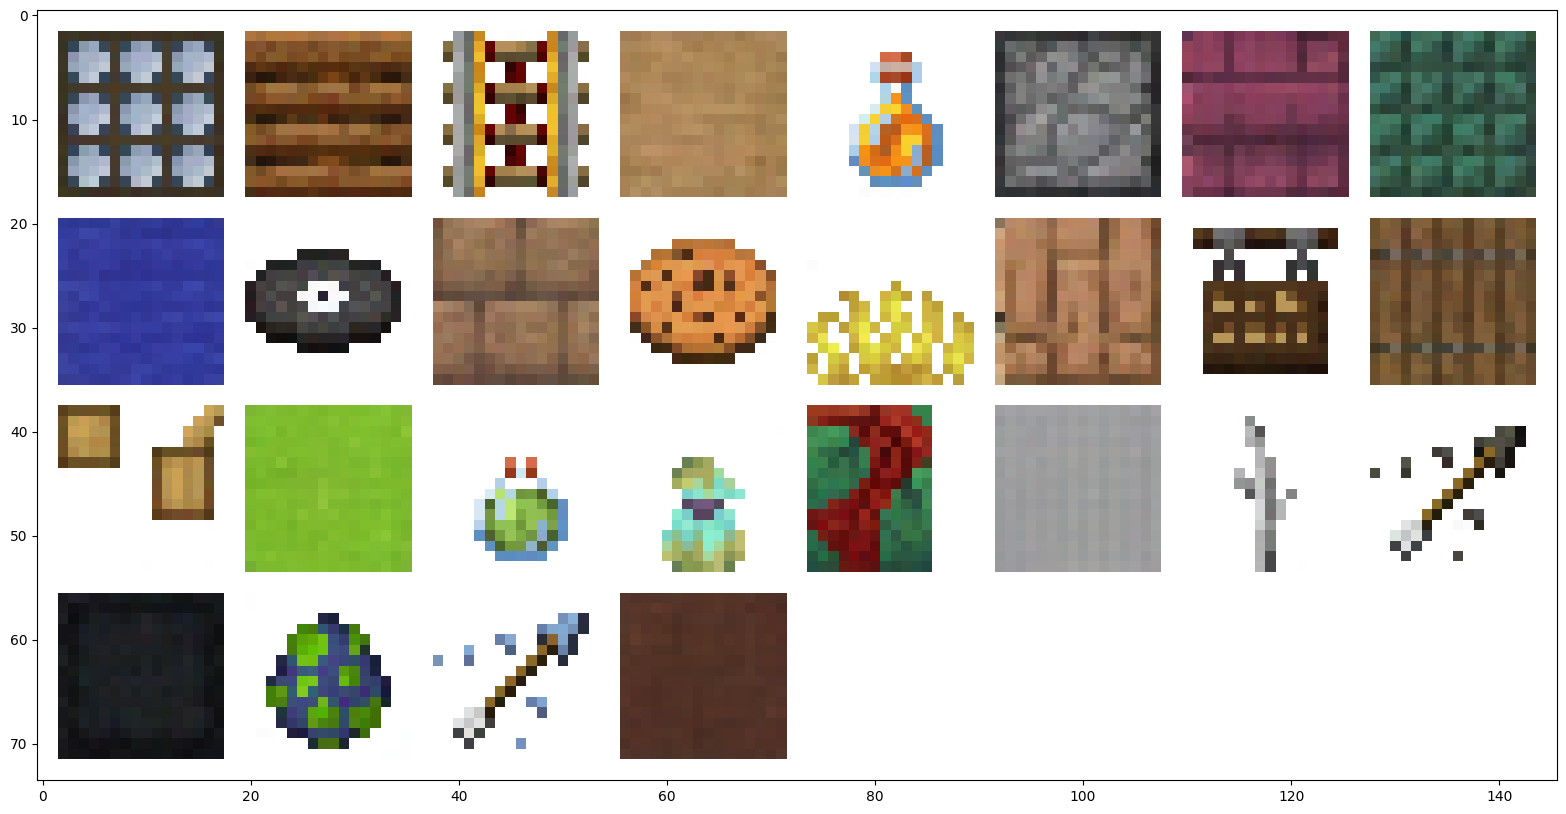

In [52]:
# reconstruction
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:28], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [53]:
import gc
gc.collect()
torch.cuda.empty_cache()